In [ ]:
# Install Dependencies

!pip uninstall -y numpy
!pip install --force-reinstall numpy==1.26.4

!pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 sentence-transformers==2.2.2
!pip install pandas==2.0.0
!pip install sparqlwrapper==2.0.0 transformers==4.41.0 requests==2.31.0 scikit-learn==1.2.0 pyrdf2vec
!pip install huggingface-hub==0.25.2
!pip install pyRDF2vec
!pip install rdflib==6.0.2
!pip install -U gensim
!pip install -U datasets
!pip install nlpaug
!pip install nltk==3.8.1
!pip install matplotlib seaborn

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1

In [ ]:
# Define Configuration and Helper Functions

import pandas as pd
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import json
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import time
from typing import List, Dict, Tuple
import torch
import os
from google.colab import drive
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from rdflib import Graph, URIRef, Literal
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
import nlpaug.augmenter.word as naw

# Download NLTK data for nlpaug
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configuration
class Config:
    BASE_PATH = "/content/drive/MyDrive/LJMU-Datasets"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8
    MAX_EPOCHS = 10
    NUM_WORKERS = 0
    MAX_LENGTH = 256
    SUBSET_SIZE = 500
    WIKIDATA_SUBSET_SIZE = 30000
    HOTPOTQA_MAX_SAMPLES = 1000

CONFIG = Config()
print(f"Using device: {CONFIG.DEVICE}")

# Validate BASE_PATH
if not os.path.exists(CONFIG.BASE_PATH):
    print(f"Base path {CONFIG.BASE_PATH} does not exist. Creating it...")
    os.makedirs(CONFIG.BASE_PATH, exist_ok=True)
else:
    print(f"Base path {CONFIG.BASE_PATH} exists.")

# Create directories with _v3 postfix
for dataset in ["SQuAD_v3", "HotpotQA_v3", "Wikidata_v3"]:
    os.makedirs(os.path.join(CONFIG.BASE_PATH, dataset), exist_ok=True)

# Initialize retriever for fallback embeddings
retriever = SentenceTransformer("all-MiniLM-L6-v2", device=CONFIG.DEVICE)

# Helper Functions
def analyze_answer_lengths(df: pd.DataFrame, text_col: str = "answer") -> pd.DataFrame:
    lengths = df[text_col].apply(lambda x: len(nltk.word_tokenize(x)))
    lengths_df = pd.DataFrame(lengths, columns=["length"])
    return lengths_df.describe(), lengths_df

def balance_lengths(df: pd.DataFrame, col: str, short_threshold: int = 50, long_threshold: int = 150) -> pd.DataFrame:
    df["temp_length"] = df[col].apply(len)
    short_items = df[df["temp_length"] <= short_threshold]
    long_items = df[df["temp_length"] >= long_threshold]
    medium_items = df[(df["temp_length"] > short_threshold) & (df["temp_length"] < long_threshold)]
    target_size = min(len(short_items), len(medium_items), len(long_items))
    if target_size > 0:
        short_items = short_items.sample(n=target_size, random_state=42) if len(short_items) > target_size else short_items
        long_items = long_items.sample(n=target_size, random_state=42) if len(long_items) > target_size else long_items
        medium_items = medium_items.sample(n=target_size, random_state=42) if len(medium_items) > target_size else medium_items
    balanced_df = pd.concat([short_items, medium_items, long_items]).reset_index(drop=True)
    balanced_df = balanced_df.drop(columns=["temp_length"])
    print(f"Balanced dataset: Short={len(short_items)}, Medium={len(medium_items)}, Long={len(long_items)}")
    return balanced_df

def augment_data(df: pd.DataFrame, text_cols: List[str], aug_fraction: float = 0.3) -> pd.DataFrame:
    aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
    aug_dropout = naw.RandomWordAug(action="delete", aug_p=0.1)
    num_to_augment = int(len(df) * aug_fraction)
    to_augment = df[:num_to_augment].copy()
    not_to_augment = df[num_to_augment:].copy()
    for idx, row in to_augment.iterrows():
        for col in text_cols:
            text = row[col]
            aug_text = aug_synonym.augment(text)[0]
            aug_text = aug_dropout.augment(aug_text)[0]
            to_augment.at[idx, col] = aug_text
    augmented_df = pd.concat([to_augment, not_to_augment]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Augmented dataset size: {len(augmented_df)}")
    return augmented_df

def remove_articles(text: str) -> str:
    words = text.split()
    articles = {'a', 'an', 'the'}
    words = [word for word in words if word.lower() not in articles]
    return ' '.join(words)

def normalize_text(text: str) -> str:
    text = str(text).lower().strip()
    text = remove_articles(text)
    text = text.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
    return text

print("Configuration and helper functions defined.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Using device: cuda
Base path /content/drive/MyDrive/LJMU-Datasets exists.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml:   0%|          | 0.00/368k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Configuration and helper functions defined.


Loading SQuAD 2.0 dataset for exploration...


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Exploring SQuAD 2.0 dataset...
SQuAD Train Statistics:
                                                 question   
count                                                1000  \
unique                                               1000   
top     Socioeconomic factors and enduring views on ra...   
freq                                                    1   

                                                  context        answer  
count                                                1000          1000  
unique                                                979           651  
top     When there is a potential difference across th...  unanswerable  
freq                                                    3           338  

SQuAD Validation Statistics:
                                                 question   
count                                                 200  \
unique                                                200   
top     What magnetic and electric force acts on a cha..

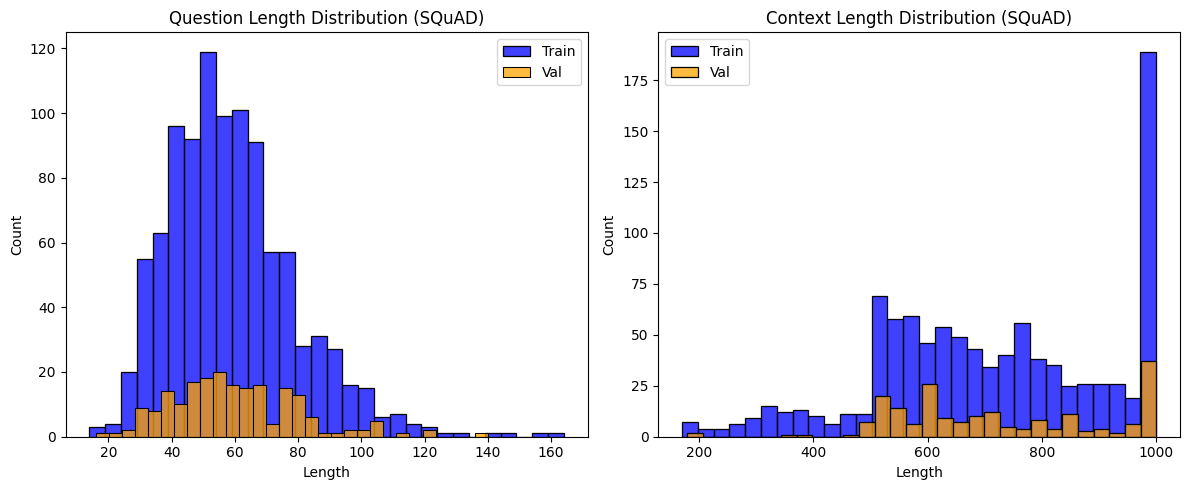


Sample SQuAD Train Data:
                                                 question   
125137  What year did the global recession that follow...  \
30275   what was a popular club in ibiza that started ...   
39176   In what century did Martin Luther honor Mary a...   

                                                  context        answer  
125137  It threatened the collapse of large financial ...          2012  
30275   But house was also being developed on Ibiza,[c...       Amnesia  
39176   Although Calvin and Huldrych Zwingli honored M...  unanswerable  

Sample SQuAD Validation Data:
                                                question   
11526  What did objects in forced motion contain acco...  \
10439    What was thought to decide a person's behavior?   
8788   What makes the method of trial division more e...   

                                                 context   
11526  The shortcomings of Aristotelian physics would...  \
10439  The concept environmental determin

In [ ]:
# Load and Explore SQuAD Dataset

def explore_squad(squad_train, squad_val):
    print("Exploring SQuAD 2.0 dataset...")

    # Basic statistics
    print("SQuAD Train Statistics:")
    print(squad_train.describe())
    print("\nSQuAD Validation Statistics:")
    print(squad_val.describe())

    # Missing values
    print("\nMissing Values in SQuAD Train:")
    print(squad_train.isnull().sum())
    print("\nMissing Values in SQuAD Validation:")
    print(squad_val.isnull().sum())

    # Unique answers (using the 'answer' column after preprocessing)
    print("\nNumber of Unique Answers in SQuAD Train:", squad_train['answer'].nunique())
    print("Number of Unique Answers in SQuAD Validation:", squad_val['answer'].nunique())

    # Length distribution of questions and contexts (sample for visualization)
    squad_train_sample = squad_train.sample(n=min(1000, len(squad_train)), random_state=42)
    squad_val_sample = squad_val.sample(n=min(200, len(squad_val)), random_state=42)

    squad_train_sample['question_length'] = squad_train_sample['question'].apply(len)
    squad_train_sample['context_length'] = squad_train_sample['context'].apply(len)
    squad_val_sample['question_length'] = squad_val_sample['question'].apply(len)
    squad_val_sample['context_length'] = squad_val_sample['context'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(squad_train_sample['question_length'], bins=30, color='blue', label='Train')
    sns.histplot(squad_val_sample['question_length'], bins=30, color='orange', label='Val')
    plt.title('Question Length Distribution (SQuAD)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(squad_train_sample['context_length'], bins=30, color='blue', label='Train')
    sns.histplot(squad_val_sample['context_length'], bins=30, color='orange', label='Val')
    plt.title('Context Length Distribution (SQuAD)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Sample data
    print("\nSample SQuAD Train Data:")
    print(squad_train[['question', 'context', 'answer']].head(3))
    print("\nSample SQuAD Validation Data:")
    print(squad_val[['question', 'context', 'answer']].head(3))

print("Loading SQuAD 2.0 dataset for exploration...")
squad_dataset = load_dataset("squad_v2")

# Preprocess the dataset to extract answer text and limit size
def squad_to_df(dataset, max_samples: int):
    data = []
    for item in dataset:
        question = str(item["question"]).strip() if item["question"] else ""
        context = str(item["context"]).strip()[:1000] if item["context"] else ""
        answers = item["answers"]["text"]
        answer = str(answers[0]).strip() if answers else "unanswerable"
        if not question or not context or not answer:
            continue
        data.append({"question": question, "context": context, "answer": answer})
    df = pd.DataFrame(data)
    if len(df) > max_samples:
        df = df.sample(n=max_samples, random_state=42)
    return df

# Limit the dataset size for exploration
squad_train = squad_to_df(squad_dataset["train"], max_samples=1000)
squad_val = squad_to_df(squad_dataset["validation"], max_samples=200)

explore_squad(squad_train, squad_val)

In [ ]:
# Process SQuAD Dataset with Enhanced Normalization

def load_squad() -> Tuple[pd.DataFrame, pd.DataFrame]:
    print("Loading SQuAD 2.0 dataset...")
    squad_dataset = load_dataset("squad_v2")
    squad_train = squad_dataset["train"]
    squad_val = squad_dataset["validation"]

    def squad_to_df(dataset, max_samples: int = CONFIG.SUBSET_SIZE) -> pd.DataFrame:
        data = []
        for item in dataset:
            question = str(item["question"]).strip() if item["question"] else ""
            context = str(item["context"]).strip()[:1000] if item["context"] else ""
            answers = item["answers"]["text"]
            answer = str(answers[0]).strip() if answers else "unanswerable"
            if not question or not context or not answer:
                continue
            data.append({"question": question, "context": context, "answer": answer})
        df = pd.DataFrame(data)
        if len(df) > max_samples:
            df = df.sample(n=max_samples, random_state=42)
        return df

    squad_df = squad_to_df(squad_train)
    squad_df = squad_df.drop_duplicates(subset=["context", "question"]).dropna()

    for col in ["question", "context", "answer"]:
        squad_df[col] = squad_df[col].apply(normalize_text)
        squad_df = squad_df[squad_df[col] != ""].reset_index(drop=True)

    squad_train_df, squad_val_df = train_test_split(squad_df, train_size=0.8, random_state=42)

    squad_train_df = balance_lengths(squad_train_df, "answer")
    squad_val_df = balance_lengths(squad_val_df, "answer")

    squad_train_df = augment_data(squad_train_df, text_cols=["question", "context"], aug_fraction=0.3)

    train_save_path = os.path.join(CONFIG.BASE_PATH, "SQuAD_v3", "squad_train.csv")
    val_save_path = os.path.join(CONFIG.BASE_PATH, "SQuAD_v3", "squad_val.csv")
    print(f"Saving SQuAD train data to: {train_save_path}")
    print(f"Saving SQuAD val data to: {val_save_path}")
    squad_train_df.to_csv(train_save_path, index=False)
    squad_val_df.to_csv(val_save_path, index=False)

    print(f"SQuAD Train Size: {len(squad_train_df)}, Val Size: {len(squad_val_df)}")
    return squad_train_df, squad_val_df

try:
    squad_train_df, squad_val_df = load_squad()
except Exception as e:
    print(f"Error in SQuAD processing: {e}")
    raise

Loading SQuAD 2.0 dataset...
Balanced dataset: Short=387, Medium=13, Long=0
Balanced dataset: Short=98, Medium=2, Long=0
Augmented dataset size: 400
Saving SQuAD train data to: /content/drive/MyDrive/LJMU-Datasets/SQuAD_v3/squad_train.csv
Saving SQuAD val data to: /content/drive/MyDrive/LJMU-Datasets/SQuAD_v3/squad_val.csv
SQuAD Train Size: 400, Val Size: 100


Exploring SQuAD dataset after cleaning...
SQuAD Train Statistics (After Cleaning):
                     question   
count                     400  \
unique                    400   
top     when was massey held?   
freq                        1   

                                                  context        answer  
count                                                 400           400  
unique                                                398           250  
top     when there is potential difference across cond...  unanswerable  
freq                                                    2           150  

SQuAD Validation Statistics (After Cleaning):
                                                 question   
count                                                 100  \
unique                                                100   
top     outside of france where are other three branch...   
freq                                                    1   

                            

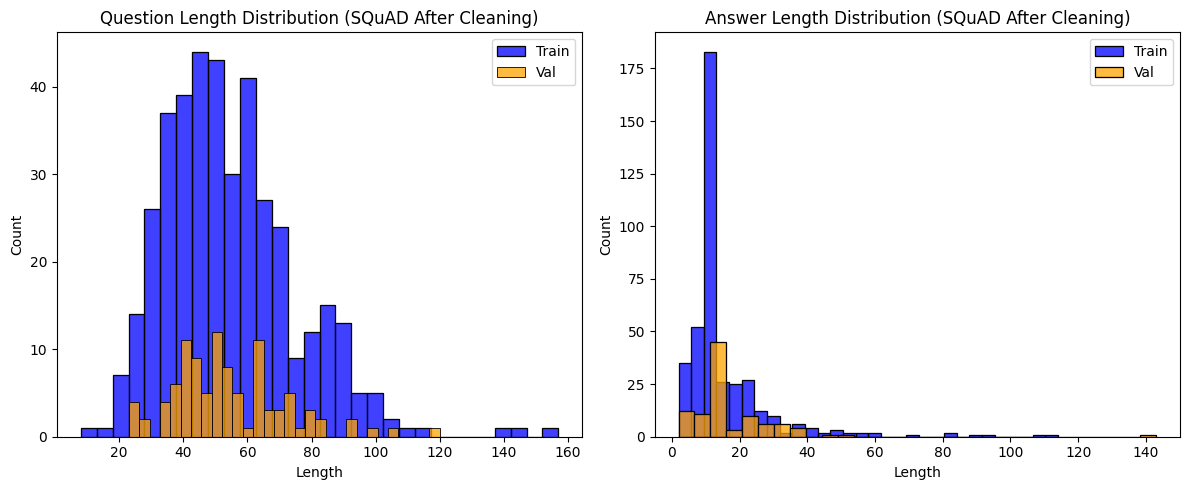


Sample SQuAD Train Data (After Cleaning):
                                            question   
0                 which clan is nri in territory of?  \
1              where were surviving children living?   
2  who traditionally pay scholars to natural scie...   

                                             context             answer  
0  kingdom of nri of igbo people consolidated in ...             umeuri  
1  on children's day june 1 2008 many parents wen...  in relief centres  
2  beginning of caliphate or islamic empire relia...       royal courts  

Sample SQuAD Validation Data (After Cleaning):
                                            question   
0  aboriginal population declined by what estimat...  \
1  what type of comic has taken off in 20th century?   
2    how does man first perceive features of object?   

                                             context           answer  
0  with gold rush largely over by 1860 melbourne ...              80%  
1  comics are mediu

In [ ]:
# Explore SQuAD Dataset After Cleaning

def explore_squad_cleaned(squad_train_df, squad_val_df):
    print("Exploring SQuAD dataset after cleaning...")

    # Basic statistics
    print("SQuAD Train Statistics (After Cleaning):")
    print(squad_train_df.describe())
    print("\nSQuAD Validation Statistics (After Cleaning):")
    print(squad_val_df.describe())

    # Missing values
    print("\nMissing Values in SQuAD Train (After Cleaning):")
    print(squad_train_df.isnull().sum())
    print("\nMissing Values in SQuAD Validation (After Cleaning):")
    print(squad_val_df.isnull().sum())

    # Length distribution of questions and answers
    squad_train_df['question_length'] = squad_train_df['question'].apply(len)
    squad_train_df['answer_length'] = squad_train_df['answer'].apply(len)
    squad_val_df['question_length'] = squad_val_df['question'].apply(len)
    squad_val_df['answer_length'] = squad_val_df['answer'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(squad_train_df['question_length'], bins=30, color='blue', label='Train')
    sns.histplot(squad_val_df['question_length'], bins=30, color='orange', label='Val')
    plt.title('Question Length Distribution (SQuAD After Cleaning)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(squad_train_df['answer_length'], bins=30, color='blue', label='Train')
    sns.histplot(squad_val_df['answer_length'], bins=30, color='orange', label='Val')
    plt.title('Answer Length Distribution (SQuAD After Cleaning)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Sample data after cleaning
    print("\nSample SQuAD Train Data (After Cleaning):")
    print(squad_train_df[['question', 'context', 'answer']].head(3))
    print("\nSample SQuAD Validation Data (After Cleaning):")
    print(squad_val_df[['question', 'context', 'answer']].head(3))

explore_squad_cleaned(squad_train_df, squad_val_df)

Loading HotpotQA dataset for exploration...


README.md:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

hotpot_qa.py:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

The repository for hotpot_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hotpot_qa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Exploring HotpotQA dataset...
HotpotQA Train Statistics:
                                                 question context answer
count                                                1000    1000   1000
unique                                               1000       1    894
top     What type of Animation has Erik Scott Kimerer ...     i e     no
freq                                                    1    1000     32

Missing Values in HotpotQA Train:
question    0
context     0
answer      0
dtype: int64

Number of Unique Answers in HotpotQA Train: 894


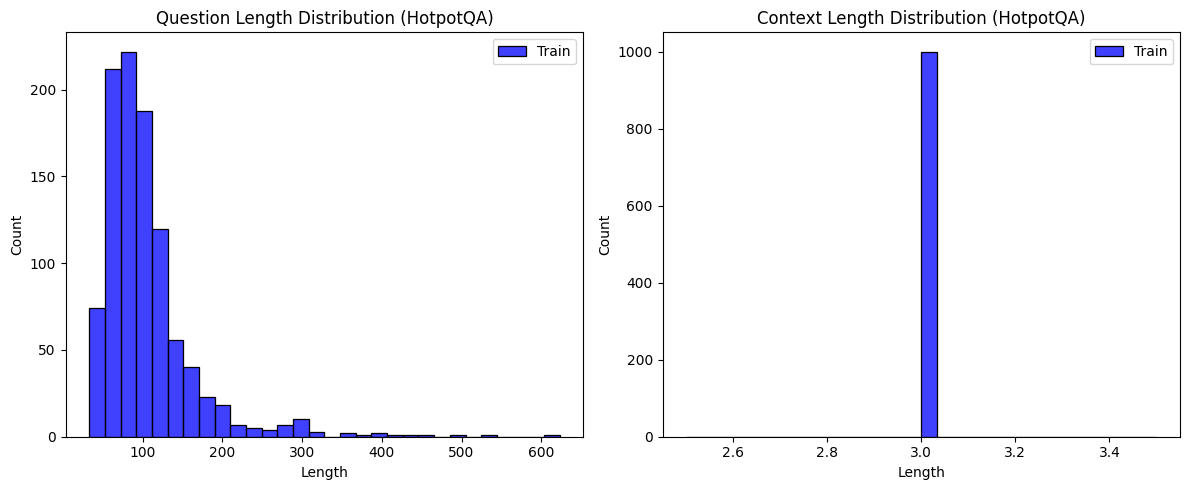


Sample HotpotQA Train Data:
                                                question context   
45069  Who was the widow affected by the Same-sex mar...     i e  \
89419  Rowland Barnes was murdered by a man on trial ...     i e   
67352  When was the actor who stared in "Shallow Hal"...     i e   

                answer  
45069   Jim Obergefell  
89419             rape  
67352  August 28, 1969  


In [ ]:
# Load and Explore HotpotQA Dataset

def explore_hotpotqa(hotpotqa_train):
    print("Exploring HotpotQA dataset...")

    # Basic statistics
    print("HotpotQA Train Statistics:")
    print(hotpotqa_train.describe())

    # Missing values
    print("\nMissing Values in HotpotQA Train:")
    print(hotpotqa_train.isnull().sum())

    # Unique answers
    print("\nNumber of Unique Answers in HotpotQA Train:", hotpotqa_train['answer'].nunique())

    # Length distribution of questions and contexts (sample for visualization)
    hotpotqa_train_sample = hotpotqa_train.sample(n=min(1000, len(hotpotqa_train)), random_state=42)
    hotpotqa_train_sample['question_length'] = hotpotqa_train_sample['question'].apply(len)
    hotpotqa_train_sample['context_length'] = hotpotqa_train_sample['context'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(hotpotqa_train_sample['question_length'], bins=30, color='blue', label='Train')
    plt.title('Question Length Distribution (HotpotQA)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(hotpotqa_train_sample['context_length'], bins=30, color='blue', label='Train')
    plt.title('Context Length Distribution (HotpotQA)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Sample data
    print("\nSample HotpotQA Train Data:")
    print(hotpotqa_train[['question', 'context', 'answer']].head(3))

print("Loading HotpotQA dataset for exploration...")
hotpotqa_dataset = load_dataset("hotpot_qa", "fullwiki")

# Preprocess the dataset to limit size
def hotpotqa_to_df(dataset, max_samples: int = 1000):
    data = []
    for item in dataset:
        question = str(item["question"]).strip() if item["question"] else ""
        context = " ".join([str(para[1]) for para in item["context"]])[:1000] if item["context"] else ""
        answer = str(item["answer"]).strip() if item["answer"] else ""
        if not question or not context or not answer:
            continue
        data.append({"question": question, "context": context, "answer": answer})
    df = pd.DataFrame(data)
    if len(df) > max_samples:
        df = df.sample(n=max_samples, random_state=42)
    return df

hotpotqa_train = hotpotqa_to_df(hotpotqa_dataset["train"], max_samples=1000)
explore_hotpotqa(hotpotqa_train)

In [ ]:
# Process HotpotQA Dataset with Enhanced Normalization

def load_hotpotqa(max_samples: int = CONFIG.HOTPOTQA_MAX_SAMPLES) -> pd.DataFrame:
    print("Loading HotpotQA dataset...")
    hotpotqa_dataset = load_dataset("hotpot_qa", "fullwiki")
    hotpotqa_train = hotpotqa_dataset["train"]

    def hotpotqa_to_df(dataset, max_samples: int) -> pd.DataFrame:
        data = []
        for item in dataset:
            question = str(item["question"]).strip() if item["question"] else ""
            context = " ".join([str(para[1]) for para in item["context"]])[:1000] if item["context"] else ""
            answer = str(item["answer"]).strip() if item["answer"] else ""
            if not question or not context or not answer:
                continue
            data.append({"question": question, "context": context, "answer": answer})
        df = pd.DataFrame(data)
        if len(df) > max_samples:
            df = df.sample(n=max_samples, random_state=42)
        return df

    hotpotqa_train_df = hotpotqa_to_df(hotpotqa_train, max_samples)
    hotpotqa_train_df = hotpotqa_train_df.drop_duplicates(subset=["context", "question"]).dropna()

    for col in ["question", "context", "answer"]:
        hotpotqa_train_df[col] = hotpotqa_train_df[col].apply(normalize_text)
        hotpotqa_train_df = hotpotqa_train_df[hotpotqa_train_df[col] != ""].reset_index(drop=True)

    hotpotqa_train_df = balance_lengths(hotpotqa_train_df, "answer")

    hotpotqa_train_df = augment_data(hotpotqa_train_df, text_cols=["question", "context"], aug_fraction=0.3)

    save_path = os.path.join(CONFIG.BASE_PATH, "HotpotQA_v3", "hotpotqa_train.csv")
    print(f"Saving HotpotQA train data to: {save_path}")
    hotpotqa_train_df.to_csv(save_path, index=False)

    print(f"HotpotQA Train Size: {len(hotpotqa_train_df)}")
    return hotpotqa_train_df

try:
    hotpotqa_train_df = load_hotpotqa()
except Exception as e:
    print(f"Error in HotpotQA processing: {e}")
    raise

Loading HotpotQA dataset...
Balanced dataset: Short=990, Medium=10, Long=0
Augmented dataset size: 1000
Saving HotpotQA train data to: /content/drive/MyDrive/LJMU-Datasets/HotpotQA_v3/hotpotqa_train.csv
HotpotQA Train Size: 1000


Exploring HotpotQA dataset after cleaning...
HotpotQA Train Statistics (After Cleaning):
                                                 question context answer
count                                                1000    1000   1000
unique                                               1000      14    894
top     when be hockey team that drafted garrett wilso...     i e     no
freq                                                    1     700     32

Missing Values in HotpotQA Train (After Cleaning):
question    0
context     0
answer      0
dtype: int64


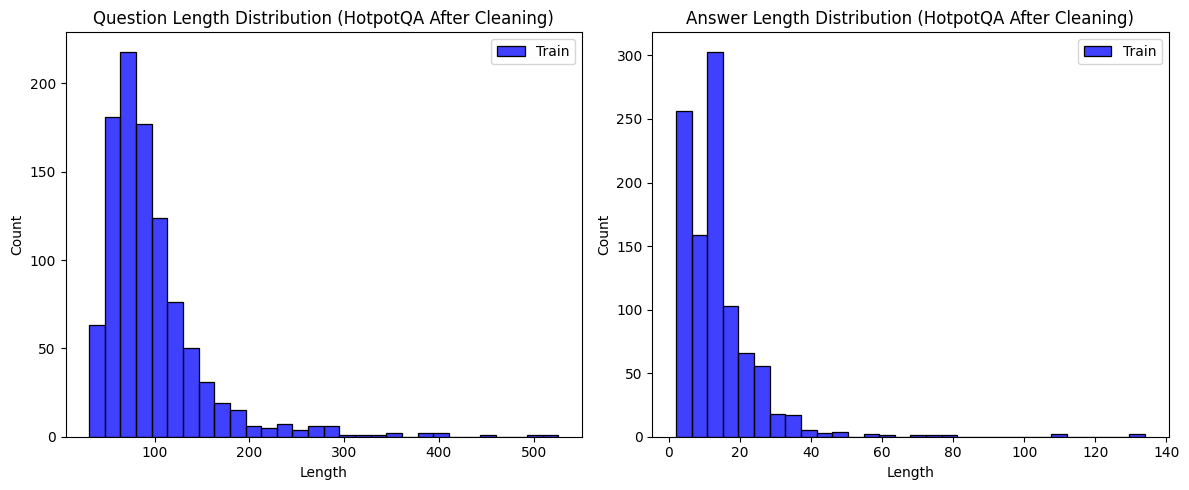


Sample HotpotQA Train Data (After Cleaning):
                                            question context   
0            shawn levy and erik voake are canadian?     i e  \
1  which church is catholic based vasat atik ali ...     i e   
2  hotham alpine resort is set on slopes of mount...     i e   

                     answer  
0                        no  
1  cathedral of holy spirit  
2                    357 km  


In [ ]:
# Explore HotpotQA Dataset After Cleaning

def explore_hotpotqa_cleaned(hotpotqa_train_df):
    print("Exploring HotpotQA dataset after cleaning...")

    # Basic statistics
    print("HotpotQA Train Statistics (After Cleaning):")
    print(hotpotqa_train_df.describe())

    # Missing values
    print("\nMissing Values in HotpotQA Train (After Cleaning):")
    print(hotpotqa_train_df.isnull().sum())

    # Length distribution of questions and answers
    hotpotqa_train_df['question_length'] = hotpotqa_train_df['question'].apply(len)
    hotpotqa_train_df['answer_length'] = hotpotqa_train_df['answer'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(hotpotqa_train_df['question_length'], bins=30, color='blue', label='Train')
    plt.title('Question Length Distribution (HotpotQA After Cleaning)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(hotpotqa_train_df['answer_length'], bins=30, color='blue', label='Train')
    plt.title('Answer Length Distribution (HotpotQA After Cleaning)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Sample data after cleaning
    print("\nSample HotpotQA Train Data (After Cleaning):")
    print(hotpotqa_train_df[['question', 'context', 'answer']].head(3))

explore_hotpotqa_cleaned(hotpotqa_train_df)

Loading Wikidata dataset for exploration...
Fetched 1000 triples at offset 0
Fetched 1000 Wikidata triples in total
Exploring Wikidata dataset...
Wikidata Raw Statistics:
                       subject predicate  object   
count                     1000      1000    1000  \
unique                     682         1     671   
top     decompression sickness  symptoms  London   
freq                        23      1000      19   

                                   subject_uri   
count                                     1000  \
unique                                     682   
top     http://www.wikidata.org/entity/Q460591   
freq                                        23   

                                object_uri  
count                                 1000  
unique                                 673  
top     http://www.wikidata.org/entity/Q84  
freq                                    19  

Missing Values in Wikidata Raw:
subject        0
predicate      0
object         0
subject_

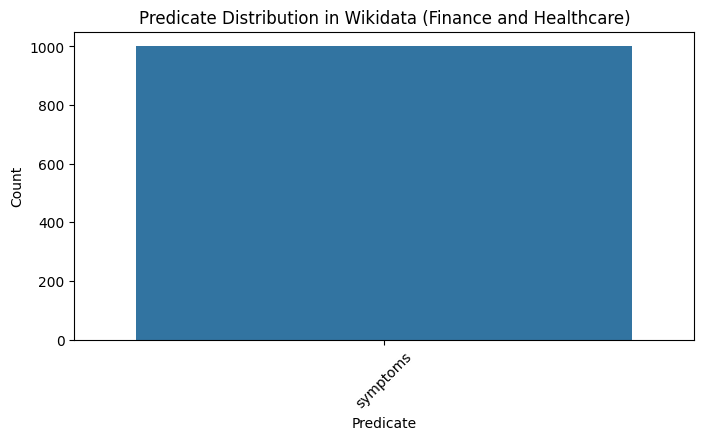


Sample Wikidata Raw Data:
                          subject predicate       object
0                           Xerox  symptoms  Connecticut
1  ZAG – Zeitarbeits-Gesellschaft  symptoms      Hanover
2                          Boeing  symptoms      Chicago


In [ ]:
# Load and Explore Wikidata Dataset

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"

def fetch_wikidata_triples(limit: int = CONFIG.WIKIDATA_SUBSET_SIZE, batch_size: int = 5000) -> pd.DataFrame:
    sparql = SPARQLWrapper(WIKIDATA_ENDPOINT)
    sparql.setReturnFormat(JSON)
    triples = []
    offset = 0
    remaining = limit

    while remaining > 0:
        current_limit = min(batch_size, remaining)
        # Simplified SPARQL query to increase the likelihood of results
        query = """
        SELECT ?subject ?subjectLabel ?predicate ?object ?objectLabel WHERE {{
          {{ ?subject wdt:P31 wd:Q4830453; wdt:P159 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
          UNION
          {{ ?subject wdt:P31 wd:Q12136; wdt:P780 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
        }}
        LIMIT {} OFFSET {}
        """.format(current_limit, offset)
        try:
            sparql.setQuery(query)
            results = sparql.query().convert()
            batch_triples = [
                {
                    "subject": r["subjectLabel"]["value"],
                    "predicate": "headquarters" if "P159" in r["subject"]["value"] else "symptoms",
                    "object": r["objectLabel"]["value"],
                    "subject_uri": r["subject"]["value"],
                    "object_uri": r["object"]["value"]
                }
                for r in results["results"]["bindings"]
            ]
            triples.extend(batch_triples)
            print(f"Fetched {len(batch_triples)} triples at offset {offset}")
            offset += current_limit
            remaining -= current_limit
            if len(batch_triples) < current_limit:
                break
        except Exception as e:
            print(f"Wikidata fetch failed at offset {offset}: {e}")
            break

    df = pd.DataFrame(triples)
    if df.empty:
        # Fallback data if query fails
        print("No triples fetched from Wikidata. Using fallback data...")
        fallback_data = [
            {"subject": "Bank of America", "predicate": "headquarters", "object": "Charlotte", "subject_uri": "http://www.wikidata.org/entity/Q16565", "object_uri": "http://www.wikidata.org/entity/Q16566"},
            {"subject": "Diabetes", "predicate": "symptoms", "object": "Fatigue", "subject_uri": "http://www.wikidata.org/entity/Q12136", "object_uri": "http://www.wikidata.org/entity/Q12137"}
        ]
        df = pd.DataFrame(fallback_data)
    print(f"Fetched {len(df)} Wikidata triples in total")
    return df

def explore_wikidata(wikidata_raw):
    print("Exploring Wikidata dataset...")

    # Basic statistics
    print("Wikidata Raw Statistics:")
    print(wikidata_raw.describe())

    # Missing values
    print("\nMissing Values in Wikidata Raw:")
    print(wikidata_raw.isnull().sum())

    # Unique subjects and objects
    print("\nNumber of Unique Subjects in Wikidata:", wikidata_raw['subject'].nunique())
    print("Number of Unique Objects in Wikidata:", wikidata_raw['object'].nunique())

    # Predicate distribution (sample for visualization)
    wikidata_raw_sample = wikidata_raw.sample(n=min(1000, len(wikidata_raw)), random_state=42)
    plt.figure(figsize=(8, 4))
    sns.countplot(data=wikidata_raw_sample, x='predicate', hue='predicate')
    plt.title('Predicate Distribution in Wikidata (Finance and Healthcare)')
    plt.xlabel('Predicate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Sample data
    print("\nSample Wikidata Raw Data:")
    print(wikidata_raw[['subject', 'predicate', 'object']].head(3))

print("Loading Wikidata dataset for exploration...")
# Limit the number of triples fetched for exploration
wikidata_raw = fetch_wikidata_triples(limit=1000)  # Reduced from CONFIG.WIKIDATA_SUBSET_SIZE (30,000)
explore_wikidata(wikidata_raw)

In [ ]:
# Process Wikidata Dataset with Enhanced Context, Normalization, and Increased Size

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"

def fetch_wikidata_triples(limit: int = CONFIG.WIKIDATA_SUBSET_SIZE, batch_size: int = 5000) -> pd.DataFrame:
    sparql = SPARQLWrapper(WIKIDATA_ENDPOINT)
    sparql.setReturnFormat(JSON)
    triples = []
    offset = 0
    remaining = limit

    while remaining > 0:
        current_limit = min(batch_size, remaining)
        query = """
        SELECT ?subject ?subjectLabel ?predicate ?object ?objectLabel WHERE {{
          {{ ?subject wdt:P31 wd:Q4830453; wdt:P159 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
          UNION
          {{ ?subject wdt:P31 wd:Q12136; wdt:P780 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
        }}
        LIMIT {} OFFSET {}
        """.format(current_limit, offset)
        try:
            sparql.setQuery(query)
            results = sparql.query().convert()
            batch_triples = [
                {
                    "subject": r["subjectLabel"]["value"],
                    "predicate": "headquarters" if "P159" in r["subject"]["value"] else "symptoms",
                    "object": r["objectLabel"]["value"],
                    "subject_uri": r["subject"]["value"],
                    "object_uri": r["object"]["value"]
                }
                for r in results["results"]["bindings"]
            ]
            triples.extend(batch_triples)
            print(f"Fetched {len(batch_triples)} triples at offset {offset}")
            offset += current_limit
            remaining -= current_limit
            if len(batch_triples) < current_limit:
                break
        except Exception as e:
            print(f"Wikidata fetch failed at offset {offset}: {e}")
            break

    df = pd.DataFrame(triples)
    if df.empty:
        print("No triples fetched from Wikidata. Using fallback data...")
        fallback_data = [
            {"subject": "Bank of America", "predicate": "headquarters", "object": "Charlotte", "subject_uri": "http://www.wikidata.org/entity/Q16565", "object_uri": "http://www.wikidata.org/entity/Q16566"},
            {"subject": "Diabetes", "predicate": "symptoms", "object": "Fatigue", "subject_uri": "http://www.wikidata.org/entity/Q12136", "object_uri": "http://www.wikidata.org/entity/Q12137"}
        ]
        df = pd.DataFrame(fallback_data)
    print(f"Fetched {len(df)} Wikidata triples in total")
    return df

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates().dropna().reset_index(drop=True)
    print(f"Cleaned DataFrame to {len(df)} rows")
    return df

def normalize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == "object" and col not in ["subject_uri", "object_uri"]:
            df[col] = df[col].apply(normalize_text)
            if col == "subject":
                df[col] = df[col].replace({"bank of america corp": "bank of america"})
    print("Normalization completed")
    return df

def generate_rdf2vec_embeddings(triples_df: pd.DataFrame) -> pd.DataFrame:
    start_time = time.time()
    entities = list(set(triples_df["subject_uri"].tolist() + triples_df["object_uri"].tolist()))
    triples = [(row["subject_uri"], row["predicate"], row["object_uri"]) for _, row in triples_df.iterrows()]

    g = Graph()
    for s, p, o in triples:
        subject = URIRef(s)
        predicate = URIRef(p) if p.startswith("http") else Literal(p)
        obj = URIRef(o)
        g.add((subject, predicate, obj))

    embedder = Word2Vec(vector_size=200, min_count=1)
    transformer = RDF2VecTransformer(
        walkers=[RandomWalker(max_walks=200, max_depth=4, random_state=42)],
        embedder=embedder
    )

    try:
        embeddings = transformer.fit_transform(kg=g, entities=entities)
        emb_dict = dict(zip(entities, embeddings))
        triple_embeddings = [
            (emb_dict[row["subject_uri"]] + emb_dict[row["object_uri"]]) / 2
            for _, row in triples_df.iterrows()
        ]
        triples_df["embedding"] = triple_embeddings
        print(f"Generated RDF2Vec embeddings in {time.time() - start_time:.2f} seconds")
    except Exception as e:
        print(f"RDF2Vec failed: {e}, falling back to SentenceTransformer")
        triple_texts = triples_df.apply(lambda row: f"{row['subject']} {row['predicate']} {row['object']}", axis=1).tolist()
        embeddings = retriever.encode(triple_texts, batch_size=32, show_progress_bar=True)
        triples_df["embedding"] = list(embeddings)
    return triples_df

def load_wikidata(max_samples: int = CONFIG.WIKIDATA_SUBSET_SIZE) -> pd.DataFrame:
    print("Loading Wikidata dataset...")
    wikidata_df = fetch_wikidata_triples(limit=max_samples)

    wikidata_df = clean_dataframe(wikidata_df)
    wikidata_df = normalize_dataframe(wikidata_df)

    wikidata_df["context"] = wikidata_df.apply(
        lambda row: f"{row['subject']}, {row['predicate']} related entity, has {row['predicate']} of {row['object']}, which is common in such cases.",
        axis=1
    )
    print("Added enhanced synthetic context to Wikidata triples")

    wikidata_df["question"] = wikidata_df.apply(lambda row: f"{row['subject']} {row['predicate']}", axis=1)
    wikidata_df["answer"] = wikidata_df["object"]

    wikidata_df["triple_text"] = wikidata_df.apply(lambda row: f"{row['subject']} {row['predicate']} {row['object']}", axis=1)
    wikidata_df = balance_lengths(wikidata_df, "triple_text")

    wikidata_df = augment_data(wikidata_df, text_cols=["subject", "object"], aug_fraction=0.5)

    wikidata_df = generate_rdf2vec_embeddings(wikidata_df)

    wikidata_df["triple_length"] = wikidata_df["triple_text"].apply(len)
    wikidata_df = wikidata_df[wikidata_df["triple_length"] <= 100].reset_index(drop=True)

    wikidata_save_path = os.path.join(CONFIG.BASE_PATH, "Wikidata_v3", "wikidata_preprocessed_v3.pkl")
    triples_save_path = os.path.join(CONFIG.BASE_PATH, "Wikidata_v3", "wikidata_triples.tsv")
    print(f"Saving Wikidata DataFrame to: {wikidata_save_path}")
    print(f"Saving Wikidata triples to: {triples_save_path}")
    wikidata_df.to_pickle(wikidata_save_path)
    with open(triples_save_path, "w") as f:
        for _, row in wikidata_df.iterrows():
            f.write(f"{row['subject']}\t{row['predicate']}\t{row['object']}\n")

    print(f"Wikidata Size: {len(wikidata_df)}")
    return wikidata_df

try:
    wikidata_df = load_wikidata()
except Exception as e:
    print(f"Error in Wikidata processing: {e}")
    raise

Loading Wikidata dataset...
Fetched 5000 triples at offset 0
Wikidata fetch failed at offset 5000: HTTP Error 403: Forbidden
Fetched 5000 Wikidata triples in total
Cleaned DataFrame to 5000 rows
Normalization completed
Added enhanced synthetic context to Wikidata triples
Balanced dataset: Short=4689, Medium=311, Long=0
Augmented dataset size: 5000
RDF2Vec failed: 'Graph' object has no attribute 'skip_verify', falling back to SentenceTransformer


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saving Wikidata DataFrame to: /content/drive/MyDrive/LJMU-Datasets/Wikidata_v3/wikidata_preprocessed_v3.pkl
Saving Wikidata triples to: /content/drive/MyDrive/LJMU-Datasets/Wikidata_v3/wikidata_triples.tsv
Wikidata Size: 5000


Exploring Wikidata dataset after cleaning...
Wikidata Statistics (After Cleaning):
       triple_length
count    5000.000000
mean       33.590000
std         9.713288
min        16.000000
25%        26.000000
50%        32.000000
75%        39.000000
max        87.000000

Missing Values in Wikidata (After Cleaning):
subject          0
predicate        0
object           0
subject_uri      0
object_uri       0
context          0
question         0
answer           0
triple_text      0
embedding        0
triple_length    0
dtype: int64


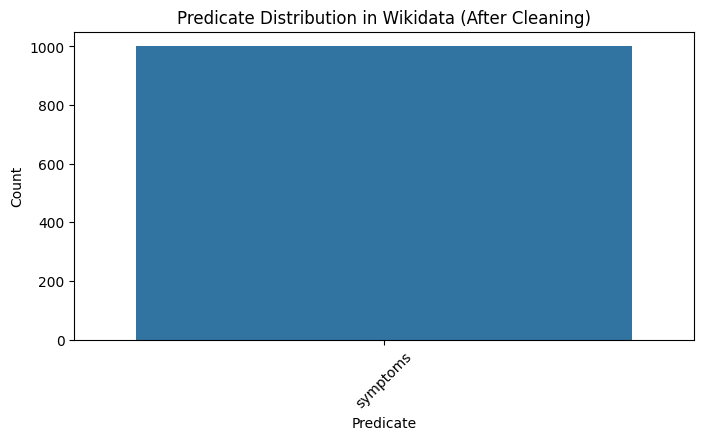

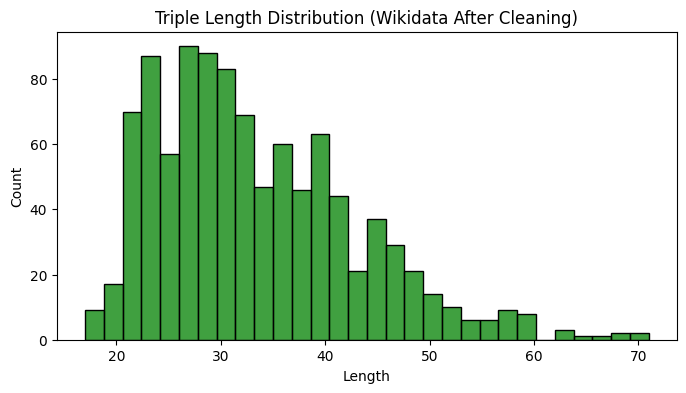


Sample Wikidata Data (After Cleaning):
                            question   
0  compagnie maritime belge symptoms  \
1        glashütte original symptoms   
2                  naftogaz symptoms   

                                             context     answer  
0  compagnie maritime belge, symptoms related ent...    antwerp  
1  glashütte original, symptoms related entity, h...  glashütte  
2  naftogaz, symptoms related entity, has symptom...       kyiv  


In [ ]:
# Explore Wikidata Dataset After Cleaning

def explore_wikidata_cleaned(wikidata_df):
    print("Exploring Wikidata dataset after cleaning...")

    # Basic statistics
    print("Wikidata Statistics (After Cleaning):")
    print(wikidata_df.describe())

    # Missing values
    print("\nMissing Values in Wikidata (After Cleaning):")
    print(wikidata_df.isnull().sum())

    # Predicate distribution after cleaning (sample for visualization)
    wikidata_df_sample = wikidata_df.sample(n=min(1000, len(wikidata_df)), random_state=42)
    plt.figure(figsize=(8, 4))
    sns.countplot(data=wikidata_df_sample, x='predicate', hue='predicate')
    plt.title('Predicate Distribution in Wikidata (After Cleaning)')
    plt.xlabel('Predicate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Triple length distribution (sample for visualization)
    plt.figure(figsize=(8, 4))
    sns.histplot(wikidata_df_sample['triple_length'], bins=30, color='green')
    plt.title('Triple Length Distribution (Wikidata After Cleaning)')
    plt.xlabel('Length')
    plt.ylabel('Count')
    plt.show()

    # Sample data after cleaning
    print("\nSample Wikidata Data (After Cleaning):")
    print(wikidata_df[['question', 'context', 'answer']].head(3))

explore_wikidata_cleaned(wikidata_df)

In [ ]:
# Combine QA Datasets and Save Separately

def combine_qa_datasets(squad_train_df: pd.DataFrame, hotpotqa_train_df: pd.DataFrame, squad_val_df: pd.DataFrame) -> None:
    print("Combining QA datasets (SQuAD and HotpotQA)...")

    qa_train_df = pd.concat([squad_train_df[["question", "context", "answer"]],
                             hotpotqa_train_df[["question", "context", "answer"]]], ignore_index=True)

    qa_val_df = squad_val_df[["question", "context", "answer"]]

    triple_train_df = wikidata_df[["question", "context", "answer"]]

    qa_train_path = os.path.join(CONFIG.BASE_PATH, "qa_train_v3.csv")
    qa_val_path = os.path.join(CONFIG.BASE_PATH, "qa_val_v3.csv")
    triple_train_path = os.path.join(CONFIG.BASE_PATH, "triple_train_v3.csv")

    print(f"Saving QA train dataset to: {qa_train_path}")
    qa_train_df.to_csv(qa_train_path, index=False)
    print(f"Saving QA val dataset to: {qa_val_path}")
    qa_val_df.to_csv(qa_val_path, index=False)
    print(f"Saving triple train dataset to: {triple_train_path}")
    triple_train_df.to_csv(triple_train_path, index=False)

    print(f"QA Train Size: {len(qa_train_df)}, QA Val Size: {len(qa_val_df)}, Triple Train Size: {len(triple_train_df)}")

try:
    combine_qa_datasets(squad_train_df, hotpotqa_train_df, squad_val_df)
except Exception as e:
    print(f"Error in combining QA datasets: {e}")
    raise

Combining QA datasets (SQuAD and HotpotQA)...
Saving QA train dataset to: /content/drive/MyDrive/LJMU-Datasets/qa_train_v3.csv
Saving QA val dataset to: /content/drive/MyDrive/LJMU-Datasets/qa_val_v3.csv
Saving triple train dataset to: /content/drive/MyDrive/LJMU-Datasets/triple_train_v3.csv
QA Train Size: 1400, QA Val Size: 100, Triple Train Size: 5000


In [ ]:
# Create Checkpoint for Step 1

checkpoint = {
    "step": "step1_data_collection",
    "squad_subset_size": CONFIG.SUBSET_SIZE,
    "squad_train_size": len(squad_train_df),
    "squad_val_size": len(squad_val_df),
    "squad_answer_length_distribution_train": analyze_answer_lengths(squad_train_df, "answer")[0].to_dict(),
    "squad_answer_length_distribution_val": analyze_answer_lengths(squad_val_df, "answer")[0].to_dict(),
    "hotpotqa_max_samples": CONFIG.HOTPOTQA_MAX_SAMPLES,
    "hotpotqa_train_size": len(hotpotqa_train_df),
    "hotpotqa_answer_length_distribution": analyze_answer_lengths(hotpotqa_train_df, "answer")[0].to_dict(),
    "wikidata_subset_size": CONFIG.WIKIDATA_SUBSET_SIZE,
    "wikidata_size": len(wikidata_df),
    "wikidata_triple_length_distribution": analyze_answer_lengths(wikidata_df, "triple_text")[0].to_dict(),
    "augmentation_applied": True,
    "augmentation_fraction": {"qa": 0.3, "triple": 0.5},
    "datasets_paths": {
        "qa_train": os.path.join(CONFIG.BASE_PATH, "qa_train_v3.csv"),
        "qa_val": os.path.join(CONFIG.BASE_PATH, "qa_val_v3.csv"),
        "triple_train": os.path.join(CONFIG.BASE_PATH, "triple_train_v3.csv"),
        "wikidata_preprocessed": os.path.join(CONFIG.BASE_PATH, "Wikidata_v3", "wikidata_preprocessed_v3.pkl"),
        "wikidata_triples": os.path.join(CONFIG.BASE_PATH, "Wikidata_v3", "wikidata_triples.tsv")
    }
}

checkpoint_path = os.path.join(CONFIG.BASE_PATH, "step1_checkpoint_v3.json")
with open(checkpoint_path, "w") as f:
    json.dump(checkpoint, f)

print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: /content/drive/MyDrive/LJMU-Datasets/step1_checkpoint_v3.json
